In [ ]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import random
import pandas as pd
import re
import plotly.express as px
import pandas as pd
import squarify
from io import StringIO
# Import libraries for visualization, mapping, and geocoding
import folium  # For creating interactive maps
import seaborn as sns  # For statistical data visualization
import matplotlib.pyplot as plt  # For plotting graphs
from geopy.geocoders import Nominatim, Photon  # For geocoding locations
from geopy.extra.rate_limiter import RateLimiter  # For rate-limiting geocoding requests
# User agents for rotation
user_agents = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Firefox/57.0',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Edge/16.16299',
]

def get_random_user_agent():
    return random.choice(user_agents)

# Wikipedia page URL
url = "https://en.wikipedia.org/wiki/List_of_largest_technology_companies_by_revenue"

# Fetch page
try:
    response = requests.get(url, headers={"User-Agent": get_random_user_agent()}, timeout=30)
    response.raise_for_status()
except requests.RequestException as exc:
    raise SystemExit(f"Request error: {exc}")

print(f"HTTP status: {response.status_code}")
print(f"Downloaded {len(response.content):,} bytes of HTML")

# Parse HTML
soup = BeautifulSoup(response.content, "html.parser")

# Required columns
REQUIRED_COLUMNS = ["Rank", "Company", "Revenue ($B) USD", "Employees", "Country (Origin)", "Headquarters"]

# Column aliases
COLUMN_ALIASES = {
    "rank": "Rank",
    "ranking": "Rank",
    "position": "Rank",
    "company": "Company",
    "organization": "Company",
    "revenue": "Revenue ($B) USD",
    "annual revenue": "Revenue ($B) USD",
    "employees": "Employees",
    "no. of employees": "Employees",
    "country": "Country (Origin)",
    "origin country": "Country (Origin)",
    "headquarters": "Headquarters",
    "hq": "Headquarters",
}

# Regex patterns
CITATION_PATTERN = re.compile(r"\[[^\]]+\]")
WHITESPACE_PATTERN = re.compile(r"\s+")

# Cleaning function
def clean_string(value):
    if pd.isna(value):
        return ""
    text = str(value)
    text = CITATION_PATTERN.sub("", text)
    text = text.replace("\xa0", " ").strip()
    return WHITESPACE_PATTERN.sub(" ", text)

# Standardize column names
def standardise_column(label):
    if isinstance(label, tuple):
        label = " ".join(str(part) for part in label if part and not pd.isna(part))
    cleaned = clean_string(label)
    slug = re.sub(r"[^a-z0-9]+", " ", cleaned.lower()).strip()

     # Fix for unnamed or "#" columns
    if slug in ("", "#", "no", "number"):
        return "Rank"
    
    if slug in COLUMN_ALIASES:
        return COLUMN_ALIASES[slug]
    # fallback
    if "rank" in slug:
        return "Rank"
    if "company" in slug:
        return "Company"
    if "revenue" in slug:
        return "Revenue ($B) USD"
    if "employee" in slug:
        return "Employees"
    if "country" in slug or "origin" in slug:
        return "Country (Origin)"
    if "head" in slug or "hq" in slug:
        return "Headquarters"
    return cleaned

# Function to extract numbers
def extract_number(value: str) -> float:
    match = re.search(r"([\d,]*\.?\d+)", str(value))
    if match:
        num = match.group(1).replace(",", "")
        return float(num)
    return 0

# Locate the 2023 table
header_2023 = soup.find("h2", id="2025_list")
if not header_2023:
    raise ValueError("2025 table header not found on the page")

table_2023 = header_2023.find_parent().find_next_sibling("table", class_="wikitable")
if not table_2023:
    raise ValueError("2025 table not found immediately after header")

# Parse table
df_2025 = pd.read_html(str(table_2023), flavor="bs4")[0]

# Standardize columns
df_2025.columns = [standardise_column(c) for c in df_2025.columns]

# Keep only required columns
for col in REQUIRED_COLUMNS:
    if col not in df_2025.columns:
        df_2025[col] = pd.NA

df_2025 = df_2025[REQUIRED_COLUMNS].copy()

# Clean all cells
df_2025 = df_2025.apply(lambda x: x.apply(clean_string)).replace("", pd.NA)
df_2025 = df_2025.dropna(subset=["Company"]).reset_index(drop=True)

# Add Year
df_2025["Year"] = 2025

# Fill Rank if still missing
if df_2025["Rank"].isna().all():
    df_2025["Rank"] = df_2025.index + 1

# Convert numeric columns
df_2025["Revenue ($B) USD"] = df_2025["Revenue ($B) USD"].apply(extract_number)
df_2025["Employees"] = df_2025["Employees"].apply(lambda x: int(extract_number(x)))

# Save CSV
df_2025.to_csv("tech_companies_2025.csv", index=False, encoding="utf-8")
print(f"Saved 2023 table with {len(df_2025)} rows")

# Display first rows
display(df_2025.head())



HTTP status: 200
Downloaded 328,774 bytes of HTML
Saved 2023 table with 25 rows


C:\Users\Preethi\AppData\Local\Temp\ipykernel_21848\1923497353.py:122: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_2025 = pd.read_html(str(table_2023), flavor="bs4")[0]


,Rank,Company,Revenue ($B) USD,Employees,Country (Origin),Headquarters,Year
0,1,Amazon,637.9,1556000,US,"Seattle, Washington & Arlington, Virginia, US",2025
1,2,Apple,416.0,166100,US,"Cupertino, California, US",2025
2,3,Alphabet,350.0,190167,US,"Mountain View, California, US",2025
3,4,Microsoft,281.7,228000,US,"Redmond, Washington, US",2025
4,5,Samsung Electronics,220.3,270372,South Korea,"Suwon, South Korea",2025


In [2]:
df_2025.shape

(25, 7)

In [3]:
# Display the column names of the DataFrame
df_2025.columns

Index(['Rank', 'Company', 'Revenue ($B) USD', 'Employees', 'Country (Origin)',
       'Headquarters', 'Year'],
      dtype='object')

In [4]:
# Generate and display descriptive statistics for the DataFrame
df_2025.describe()

,Rank,Revenue ($B) USD,Employees,Year
count,25.000000,25.000000,2.500000e+01,25.0
mean,13.000000,157.327600,2.755779e+05,2025.0
std,7.359801,137.335776,3.363407e+05,0.0
min,1.000000,55.300000,1.130000e+04,2025.0
25%,7.000000,69.000000,8.620000e+04,2025.0
50%,13.000000,112.000000,1.661000e+05,2025.0
75%,19.000000,164.500000,2.703000e+05,2025.0
max,25.000000,637.900000,1.556000e+06,2025.0


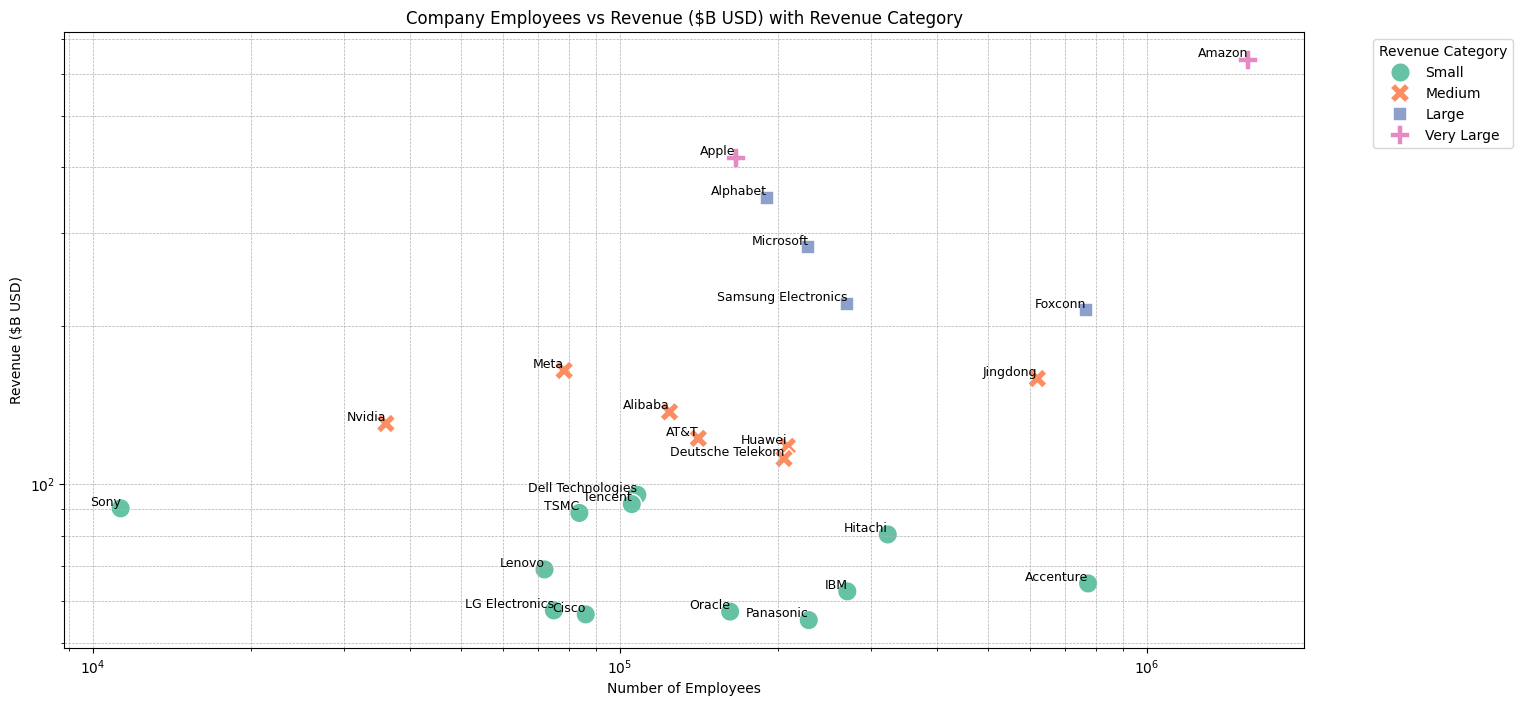

In [15]:
#Scatter plot: Employees vs Revenue, colored by Revenue Category
df_2025["Revenue ($B) USD"] = pd.to_numeric(df_2025["Revenue ($B) USD"], errors='coerce')
df_2025["Employees"] = pd.to_numeric(df_2025["Employees"], errors='coerce')

# Create Revenue Category
revenue_bins = [0, 100, 200, 400, 800]
revenue_labels = ['Small', 'Medium', 'Large', 'Very Large']
df_2025['Revenue Category'] = pd.cut(df_2025['Revenue ($B) USD'], bins=revenue_bins, labels=revenue_labels)

plt.figure(figsize=(16, 8))
sns.scatterplot(
    x='Employees',
    y='Revenue ($B) USD',
    data=df_2025,
    hue='Revenue Category',
    style='Revenue Category',
    palette='Set2',
    s=200
)

# Annotate company names on the plot
for i, row in df_2025.iterrows():
    plt.text(
        row['Employees'],
        row['Revenue ($B) USD'],
        row['Company'],
        fontsize=9,
        ha='right',
        va='bottom'
    )

plt.title('Company Employees vs Revenue ($B USD) with Revenue Category')
plt.xlabel('Number of Employees')
plt.ylabel('Revenue ($B USD)')
plt.legend(title='Revenue Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xscale('log')  # optional: log scale for Employees
plt.yscale('log')  # optional: log scale for Revenue
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig("Scatterplot_CompanyRevenue.png", dpi=50, bbox_inches='tight')
plt.show()

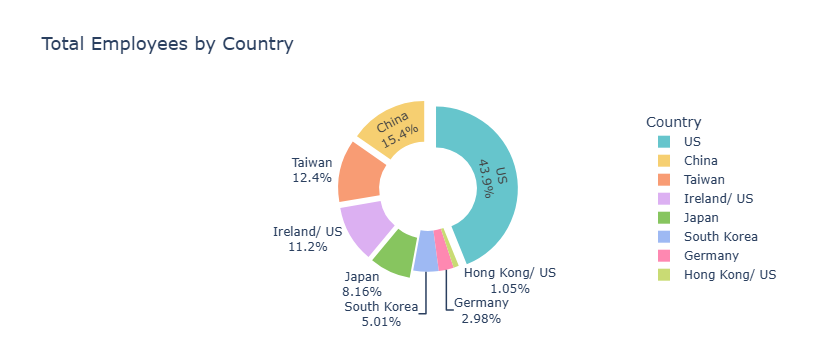

In [18]:
#Donut Pie KPI
# Ensure Employees column is numeric
df_2025["Employees"] = pd.to_numeric(df_2025["Employees"], errors='coerce')

# Group and aggregate
total_employees_by_country = (
    df_2025.groupby('Country (Origin)')['Employees']
    .sum()
    .reset_index()
    .sort_values('Employees', ascending=False)
)

# Take Top 10 countries
top_countries = total_employees_by_country.head(10)

# Create Donut Chart
fig = px.pie(
    top_countries,
    names='Country (Origin)',
    values='Employees',
    color='Country (Origin)',
    color_discrete_sequence=px.colors.qualitative.Pastel,
    hole=0.5,
    title=" Total Employees by Country"
)

# Customize hover text and layout
fig.update_traces(
    textinfo='percent+label',
    hovertemplate='<b>%{label}</b><br>Employees: %{value:,}<br>Share: %{percent}',
    pull=[0.1 if i < 5 else 0 for i in range(len(top_countries))] 
)

fig.update_layout(
    showlegend=True,
    legend_title="Country",
    title_font_size=18,
    legend=dict(yanchor="top", y=0.95, xanchor="left", x=1),
)
fig.show()


C:\Users\Preethi\AppData\Local\Temp\ipykernel_21848\25917646.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




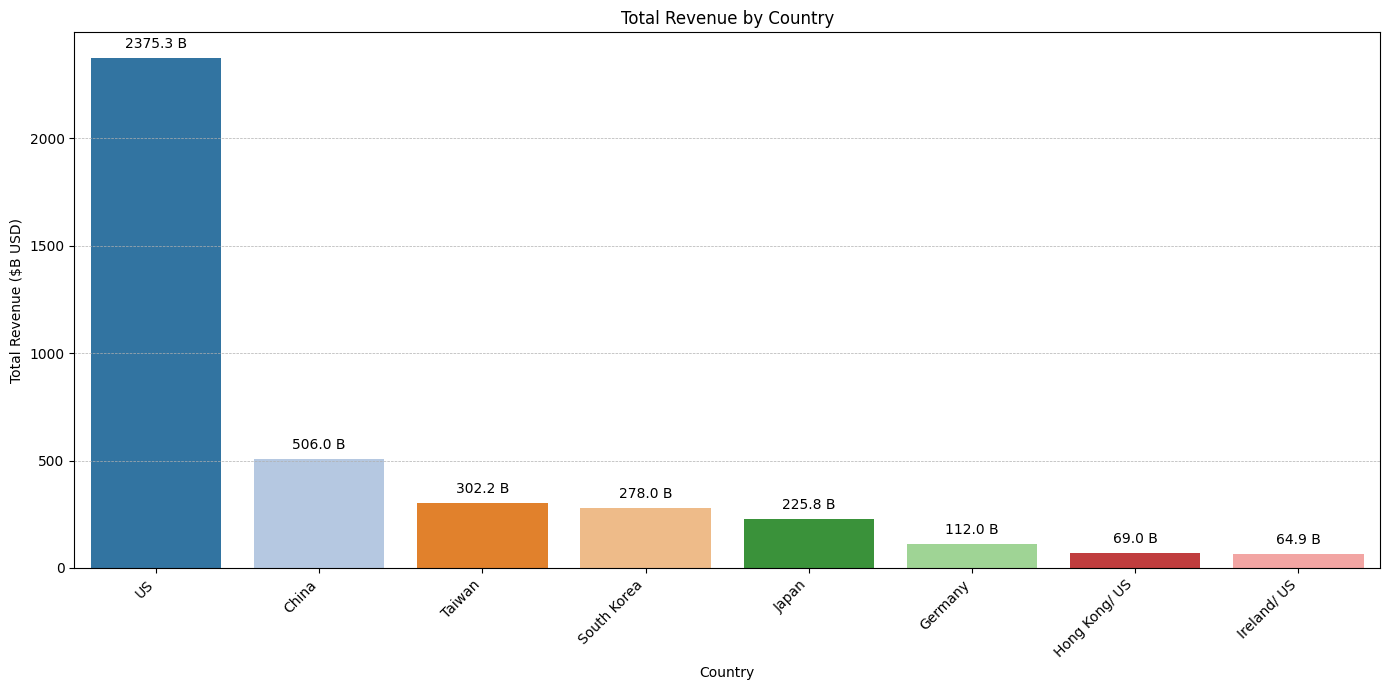

In [20]:
#bar chart
# Ensure Revenue is numeric
df_2025['Revenue ($B) USD'] = pd.to_numeric(df_2025['Revenue ($B) USD'], errors='coerce')

# Group by Country and sum Revenue
total_revenue_by_country = df_2025.groupby('Country (Origin)')['Revenue ($B) USD']\
    .sum().reset_index().sort_values('Revenue ($B) USD', ascending=False)

# Use a color palette with multiple colors (same length as number of countries)
palette = sns.color_palette("tab20", n_colors=len(total_revenue_by_country))

# Plot
plt.figure(figsize=(14, 7))
bars = sns.barplot(
    x='Country (Origin)',
    y='Revenue ($B) USD',
    data=total_revenue_by_country,
    palette=palette
)

# Add bar labels on top
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{height:.1f} B',
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5),
                  textcoords='offset points',
                  ha='center', va='bottom', fontsize=10)

plt.title('Total Revenue by Country')
plt.xlabel('Country')
plt.ylabel('Total Revenue ($B USD)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

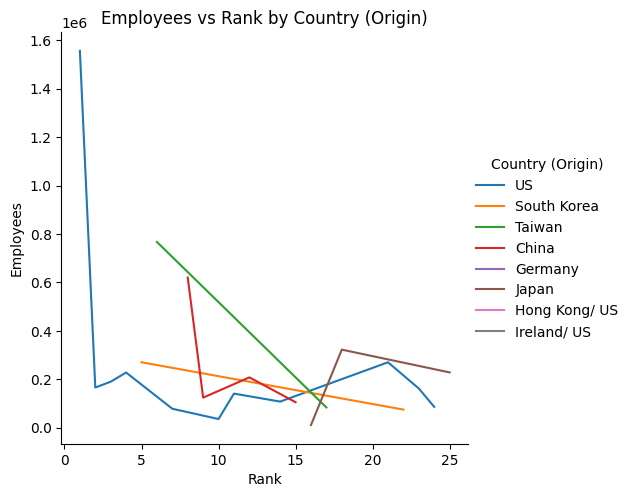

In [22]:
#Line Graph
# Assuming your DataFrame has a 'Year' column
sns.relplot(
    data=df_2025,
    kind="line",
    x="Rank",
    y="Employees",
    hue="Country (Origin)"
)

plt.title("Employees vs Rank by Country (Origin)")
plt.ylabel("Employees")
plt.xlabel("Rank")
plt.show()

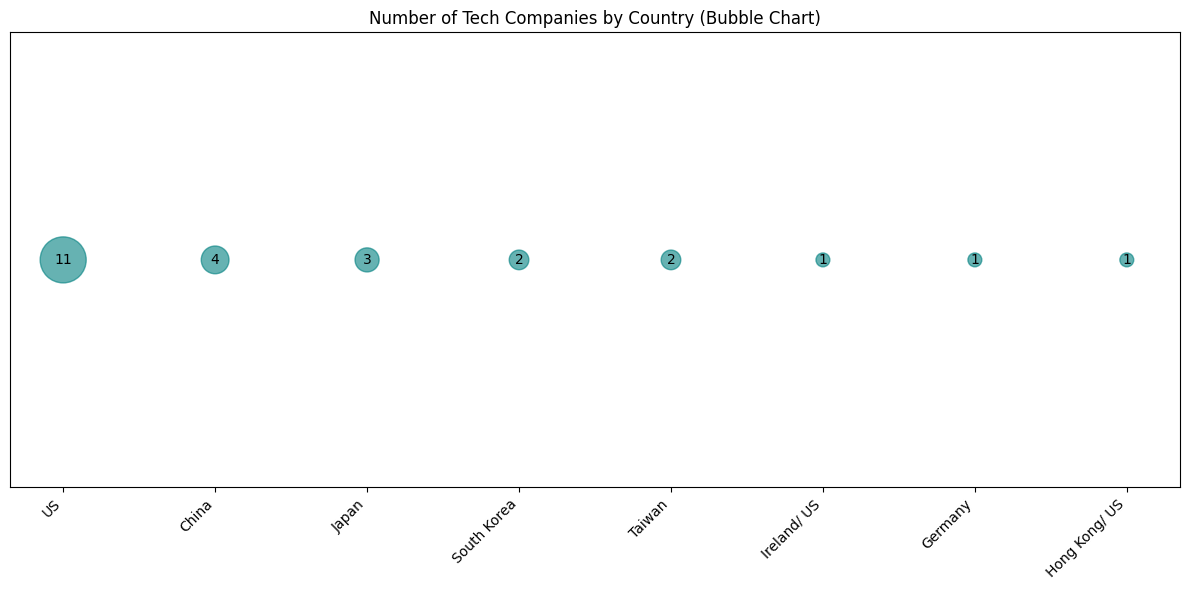

In [24]:
#Bubble chart
# Group by country and count companies
companies_by_country = (
    df_2025.groupby('Country (Origin)')['Company']
    .count()
    .reset_index()
    .sort_values('Company', ascending=False)
)

plt.figure(figsize=(12, 6))
plt.scatter(
    x=companies_by_country['Country (Origin)'],  # <-- correct column name
    y=[1]*len(companies_by_country),  # same y to align horizontally
    s=companies_by_country['Company']*100,  # bubble size proportional to count
    alpha=0.6,
    color='teal'
)

# Add labels
for i, row in companies_by_country.iterrows():
    plt.text(row['Country (Origin)'], 1, str(row['Company']), ha='center', va='center', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.yticks([])
plt.title("Number of Tech Companies by Country (Bubble Chart)")
plt.tight_layout()
plt.show()


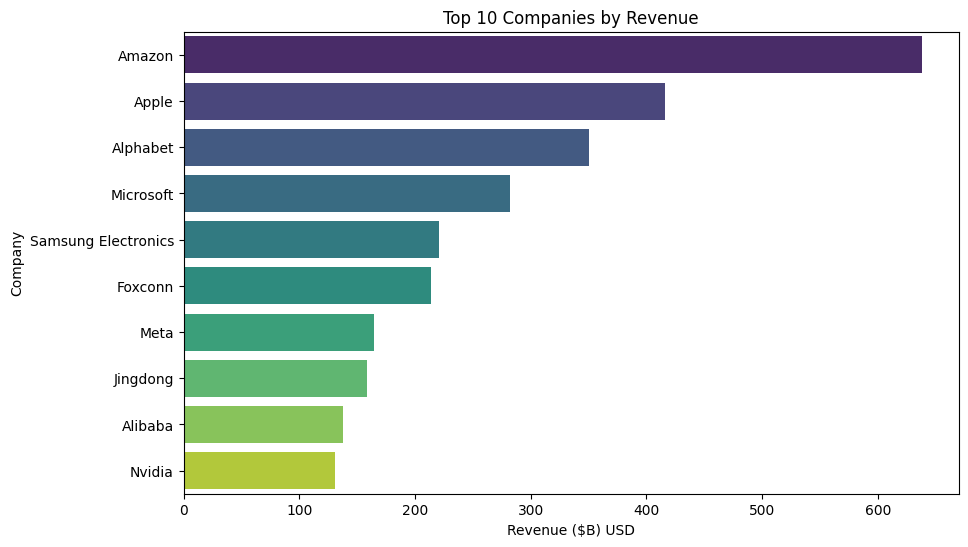

In [26]:
# Create a horizontal bar plot
# Get top 10 companies by Revenue
top_companies = df_2025.nlargest(10, 'Revenue ($B) USD')

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Revenue ($B) USD',
    y='Company',
    hue='Company',  
    data=top_companies,
    palette='viridis',
    dodge=False,
    legend=False      
)

plt.title('Top 10 Companies by Revenue')
plt.xlabel('Revenue ($B) USD')
plt.ylabel('Company')

plt.show()

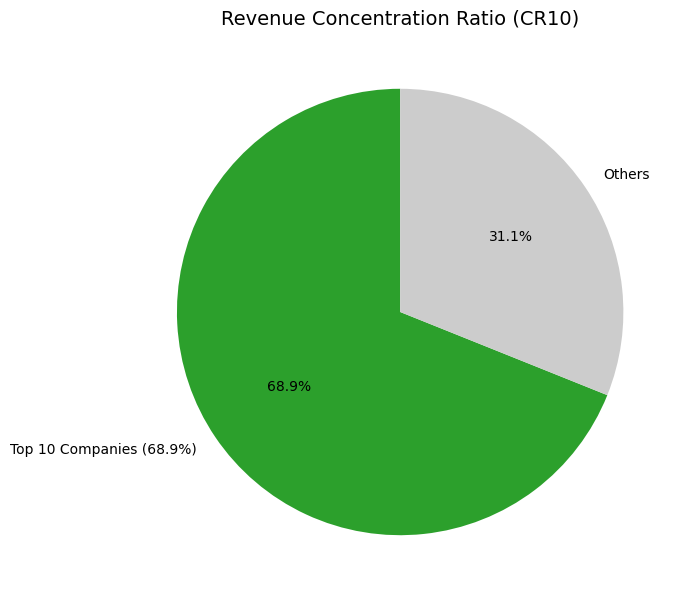

In [28]:
#Pie chart for Revenue Concentration Ratio
# Sort by revenue descending
df_sorted = df_2025.sort_values('Revenue ($B) USD', ascending=False)
total_revenue = df_sorted['Revenue ($B) USD'].sum()

# CR10 values
top10_revenue = df_sorted.head(10)['Revenue ($B) USD'].sum()
others_revenue = total_revenue - top10_revenue
cr10 = (top10_revenue / total_revenue) * 100

values = [top10_revenue, others_revenue]
labels = [f'Top 10 Companies ({cr10:.1f}%)', 'Others']
colors = ['#2ca02c', '#cccccc']

plt.figure(figsize=(7,7))
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Revenue Concentration Ratio (CR10)', fontsize=14)
plt.tight_layout()
plt.show()


                                    Headquarters  Company Count
0                        New Taipei City, Taiwan              2
1                                Shenzhen, China              2
2                                   Tokyo, Japan              2
3                  Mountain View, California, US              1
4                      Cupertino, California, US              1
5  Seattle, Washington & Arlington, Virginia, US              1
6                             Suwon, South Korea              1
7                        Redmond, Washington, US              1
8  Hangzhou, China & George Town, Cayman Islands              1
9                     Menlo Park, California, US              1


C:\Users\Preethi\AppData\Local\Temp\ipykernel_21848\2337715781.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




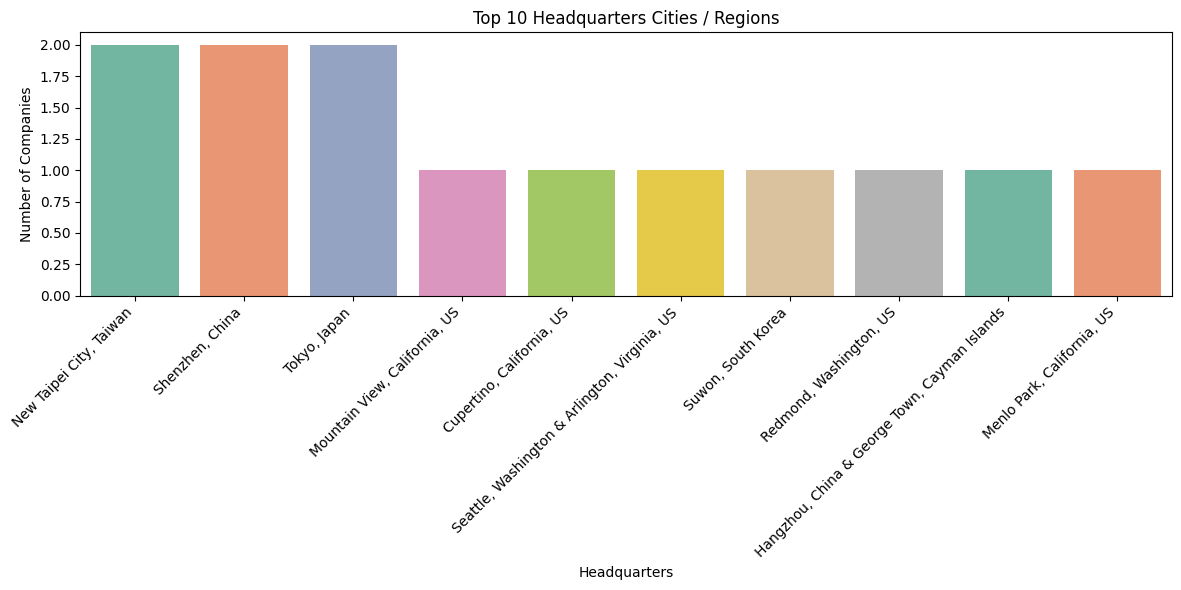

In [30]:
# Count by headquarters location
hq_counts = df_2025['Headquarters'].value_counts().reset_index()
hq_counts.columns = ['Headquarters', 'Company Count']

# Display top 10
top_hq = hq_counts.head(10)
print(top_hq)

# Plot for bar chart
plt.figure(figsize=(12,6))
sns.barplot(x='Headquarters', y='Company Count', data=top_hq, palette='Set2')
plt.title('Top 10 Headquarters Cities / Regions')
plt.xlabel('Headquarters')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

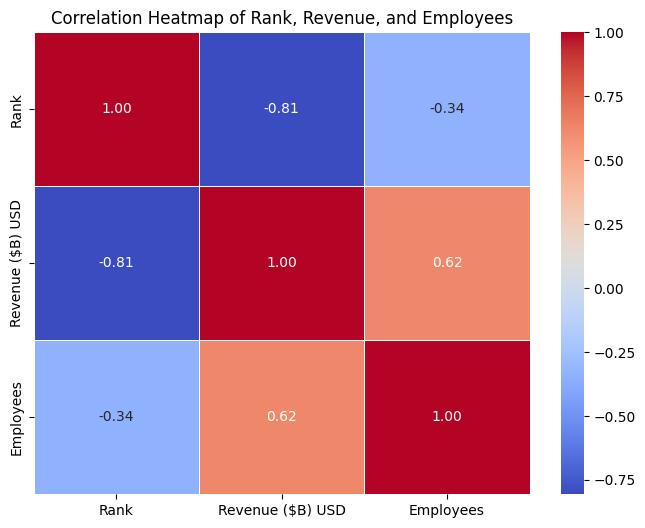

In [32]:
#Correlation Heatmap of Rank, Revenue, and Employees
# Ensure numeric types
df_2025['Revenue ($B) USD'] = pd.to_numeric(df_2025['Revenue ($B) USD'], errors='coerce')
df_2025['Employees'] = pd.to_numeric(df_2025['Employees'], errors='coerce')
df_2025['Rank'] = pd.to_numeric(df_2025['Rank'], errors='coerce')

# Select numeric columns for correlation
numeric_cols = ['Rank', 'Revenue ($B) USD', 'Employees']
corr = df_2025[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Rank, Revenue, and Employees')
plt.show()

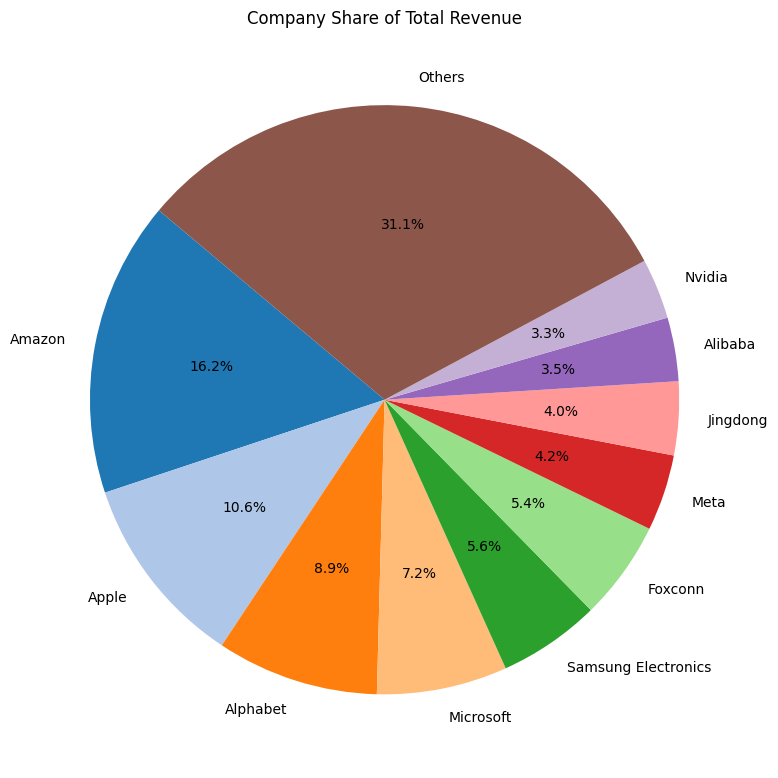

In [34]:
#Company Share of Total Revenue Pie Chart
# Sort by Revenue descending
df_sorted = df_2025.sort_values('Revenue ($B) USD', ascending=False)

# Top 10 companies
top10 = df_sorted.head(10)

# Remaining companies as "Others"
others_sum = df_sorted['Revenue ($B) USD'][10:].sum()

# Prepare data
values = list(top10['Revenue ($B) USD']) + [others_sum]
labels = list(top10['Company']) + ['Others']

# Colors
colors = plt.cm.tab20.colors  # color palette

# Plot pie chart
plt.figure(figsize=(8,8))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Company Share of Total Revenue')
plt.tight_layout()
plt.show()

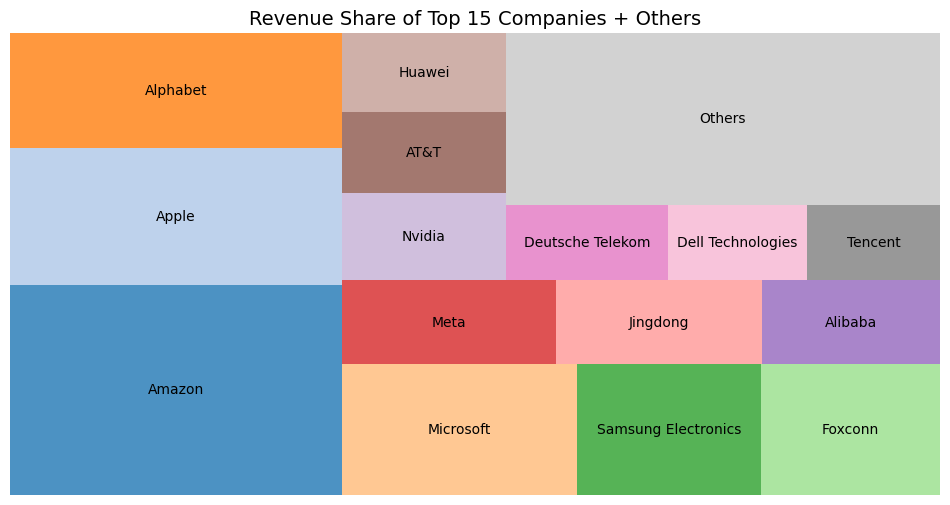

In [36]:
#treemap for revenue share of top 15companies 
# Sort companies
df_sorted = df_2025.sort_values('Revenue ($B) USD', ascending=False)

# Top 15 companies for clarity
top15 = df_sorted.head(15)
others_sum = df_sorted['Revenue ($B) USD'][15:].sum()

# Prepare data
values = list(top15['Revenue ($B) USD']) + [others_sum]
labels = list(top15['Company']) + ['Others']

# Plot treemap
plt.figure(figsize=(12,6))
squarify.plot(sizes=values, label=labels, alpha=0.8, color=plt.cm.tab20.colors)
plt.title('Revenue Share of Top 15 Companies + Others', fontsize=14)
plt.axis('off')
plt.show()

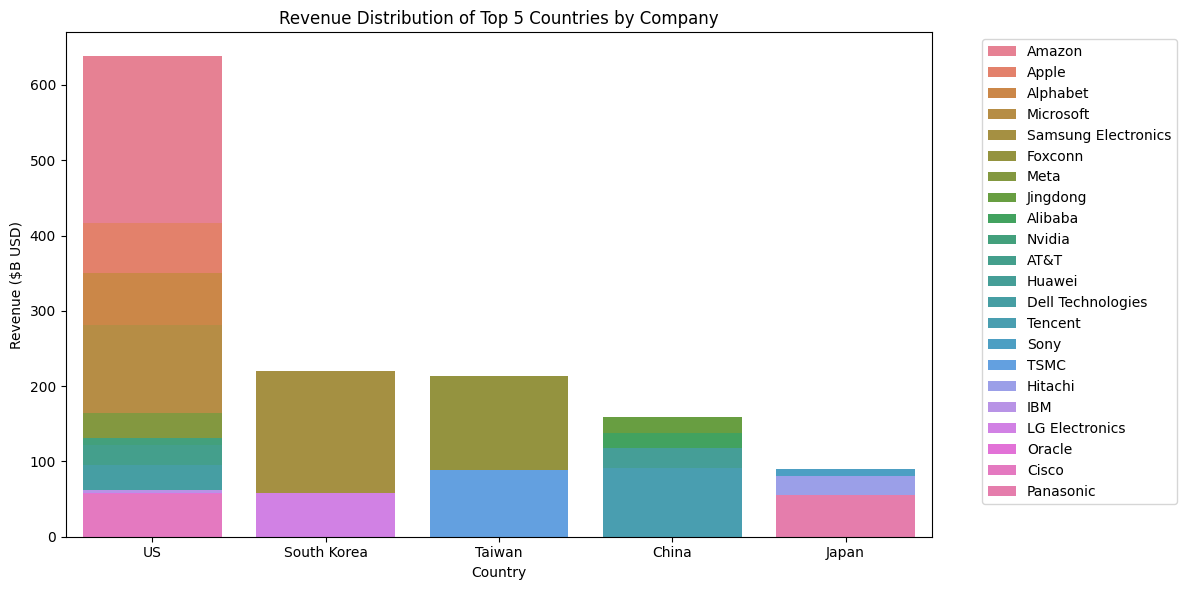

In [38]:
#Stacked Bar Graph
# Top 5 countries by total revenue
country_revenue = df_2025.groupby('Country (Origin)')['Revenue ($B) USD'].sum().sort_values(ascending=False)
top_countries = country_revenue.head(5).index
df_top_countries = df_2025[df_2025['Country (Origin)'].isin(top_countries)]

plt.figure(figsize=(12,6))
sns.barplot(x='Country (Origin)', y='Revenue ($B) USD', hue='Company', data=df_top_countries, dodge=False)
plt.title('Revenue Distribution of Top 5 Countries by Company')
plt.xlabel('Country')
plt.ylabel('Revenue ($B USD)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [39]:
# Imports
import folium
import pandas as pd
import time
from geopy.geocoders import Nominatim, Photon
from geopy.extra.rate_limiter import RateLimiter

#   Load your dataset
df = pd.read_csv("tech_companies_2023.csv")

#   Basic setup
USER_AGENT = "TechCompanyMapper/1.0 (contact: studentproject_esilv@gmail.com)"
m = folium.Map(location=[20, 0], zoom_start=2, tiles="CartoDB positron")

#   Initialize geocoders (two sources for reliability)
nominatim = Nominatim(user_agent=USER_AGENT, timeout=10)
photon = Photon(user_agent=USER_AGENT, timeout=10)

#   Rate limiters
nominatim_geocode = RateLimiter(nominatim.geocode, min_delay_seconds=1, swallow_exceptions=True)
photon_geocode = RateLimiter(photon.geocode, min_delay_seconds=1, swallow_exceptions=True)

#   Local cache to avoid re-geocoding
location_cache = {}

#   Function to geocode safely
def geocode_location(name: str):
    if not name or name.lower() in {"unknown", "n/a"}:
        return None
    if name in location_cache:
        return location_cache[name]
    
    # Try Nominatim first, then Photon
    location = nominatim_geocode(name)
    if location is None:
        location = photon_geocode(name)
    
    location_cache[name] = location
    time.sleep(1)  # polite delay
    return location

# Loop through companies and add markers
for _, row in df.iterrows():
    company = row["Company"]
    hq = str(row["Headquarters"])
    revenue = row["Revenue ($B) USD"]
    employees = row["Employees"]
    country = row["Country (Origin)"]

    # Geocode HQ
    location = geocode_location(hq)
    if location is None:
        continue

    lat, lon = location.latitude, location.longitude

    # Create a rich popup
    popup_html = f"""
    <b>{company}</b><br>
    <b>Country:</b> {country}<br>
    <b>Headquarters:</b> {hq}<br>
    <b>Revenue:</b> ${revenue} B<br>
    <b>Employees:</b> {employees:,}
    """

    # Add color scaling: larger markers for higher revenue
    color = (
        "green" if revenue < 50 else
        "orange" if revenue < 200 else
        "red"
    )

    folium.CircleMarker(
        location=[lat, lon],
        radius=6 if revenue < 50 else 9 if revenue < 200 else 12,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        tooltip=folium.Tooltip(popup_html, sticky=True)
    ).add_to(m)

#   Save map
m.save("tech_companies_map.html")




In [40]:

# Display the interactive map
m

In [41]:
# Save the map to an HTML file
m.save('Companies_by_country_map.html')